In [1]:
# import the necessary libraries
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset

# import dataloader class
from torch.utils.data import DataLoader

from torchvision import transforms, datasets

# import visualisation tool
import matplotlib.pyplot as plt

# import time to time the training
import time

# import os for image loading outside torch
import os


In [2]:
# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# define the dataset path
dataset_path = 'archive'
train_path = dataset_path + '/Training'
test_path = dataset_path + '/Testing'

# define the transforms
data_transform = transforms.Compose(
    [transforms.Resize((256, 256)), 
    transforms.ToTensor()])

# define the datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=data_transform)

# define the dataloaders with the transforms
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

Using device: cuda


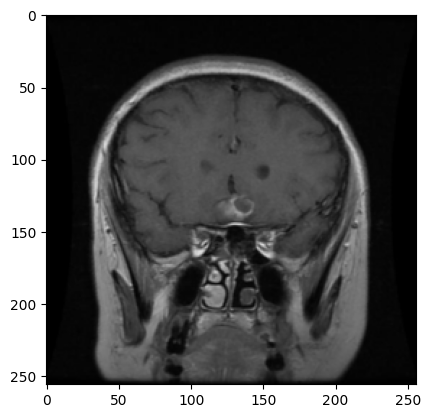

In [3]:
# show the first image in the train_loader dataset
data = next(iter(train_loader))
img = data[0][0]
plt.imshow(img.permute(1, 2, 0))

### Attempt 1: Simple CNN model with one Conv2D and one FC layer

In [4]:
# simple CNN model with one convolutional layer and one fully connected layer
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*128*128, 4))

if torch.cuda.is_available():
    model.to(device)
    train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
    test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]
    
# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
train_start = time.time()
epoch_start = time.time()
train_temp = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(n_epochs):
    model.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()}, Time: {time.time()-epoch_start:.2f} s')
    epoch_start = time.time()
print(f'Training time: {time.time()-train_start:.2f} s')
   

/home/adam/.conda/envs/torch/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/10 - Loss: 0.3313140273094177, Time: 1.42 s
Epoch 2/10 - Loss: 0.20202365517616272, Time: 1.19 s
Epoch 3/10 - Loss: 0.03620242699980736, Time: 1.20 s
Epoch 4/10 - Loss: 0.11847580224275589, Time: 1.21 s
Epoch 5/10 - Loss: 0.02792591042816639, Time: 1.20 s
Epoch 6/10 - Loss: 0.003837405936792493, Time: 1.20 s
Epoch 7/10 - Loss: 0.00899605080485344, Time: 1.20 s
Epoch 8/10 - Loss: 0.02068501152098179, Time: 1.20 s
Epoch 9/10 - Loss: 0.0018348564626649022, Time: 1.22 s
Epoch 10/10 - Loss: 0.0009368635946884751, Time: 1.22 s
Training time: 12.26 s


In [5]:
# test the model accuracy and average loss
model.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model(data)
        loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {correct/total:.2f}, Batch Loss: {loss/len(test_loader_gpu):.2f}')

Accuracy: 0.76, Batch Loss: 5.01


### Attempt 1b: Using SGD Optimizer
The purpose of this run is to illustrate why Adam is better for the initial experimentation stage due to faster convergence

In [6]:
# try again but with SGD optimizer
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*128*128, 4))

if torch.cuda.is_available():
    model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

n_epochs = 10
train_start = time.time()
epoch_start = time.time()
train_temp = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(n_epochs):
    model.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()}, Time: {time.time()-epoch_start:.2f} s')
    epoch_start = time.time()
print(f'Training time: {time.time()-train_start:.2f} s')

Epoch 1/10 - Loss: 0.8766233921051025, Time: 1.20 s
Epoch 2/10 - Loss: 0.6290332674980164, Time: 1.20 s
Epoch 3/10 - Loss: 0.5066401362419128, Time: 1.20 s
Epoch 4/10 - Loss: 0.4338745176792145, Time: 1.20 s
Epoch 5/10 - Loss: 0.38361480832099915, Time: 1.20 s
Epoch 6/10 - Loss: 0.3458508253097534, Time: 1.20 s
Epoch 7/10 - Loss: 0.3161557912826538, Time: 1.20 s
Epoch 8/10 - Loss: 0.2921085059642792, Time: 1.21 s
Epoch 9/10 - Loss: 0.27207043766975403, Time: 1.21 s
Epoch 10/10 - Loss: 0.25492578744888306, Time: 1.21 s
Training time: 12.03 s


In [7]:
# test the model accuracy
correct = 0
total = 0
model.eval()
test_temp = test_loader_gpu if torch.cuda.is_available() else test_loader
with torch.no_grad():
    for data, target in test_temp:
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 51.52284263959391%


Because of Adam's Adaptive Learning Rate, it is faster at converging (as we saw in the epochs having high loss still). We will use Adam moving forward to save time.

The accuracy (using Adam) is surprisingly high. We should be suspicious. We should check the following:
- Distribution of train and test classes
- Confusion matrix (precision/recall for each class) for the test set

In [8]:
# Let's see the distribution of the classes in the dataset for training first
class_distribution = {}
for _, target in train_loader:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("train", class_distribution)


# Let's see the distribution of the classes in the dataset for testing
class_distribution = {}
for _, target in test_loader:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("test", class_distribution)

train {3: 827, 1: 822, 0: 826, 2: 395}
test {0: 100, 2: 105, 3: 74, 1: 115}


<Axes: >

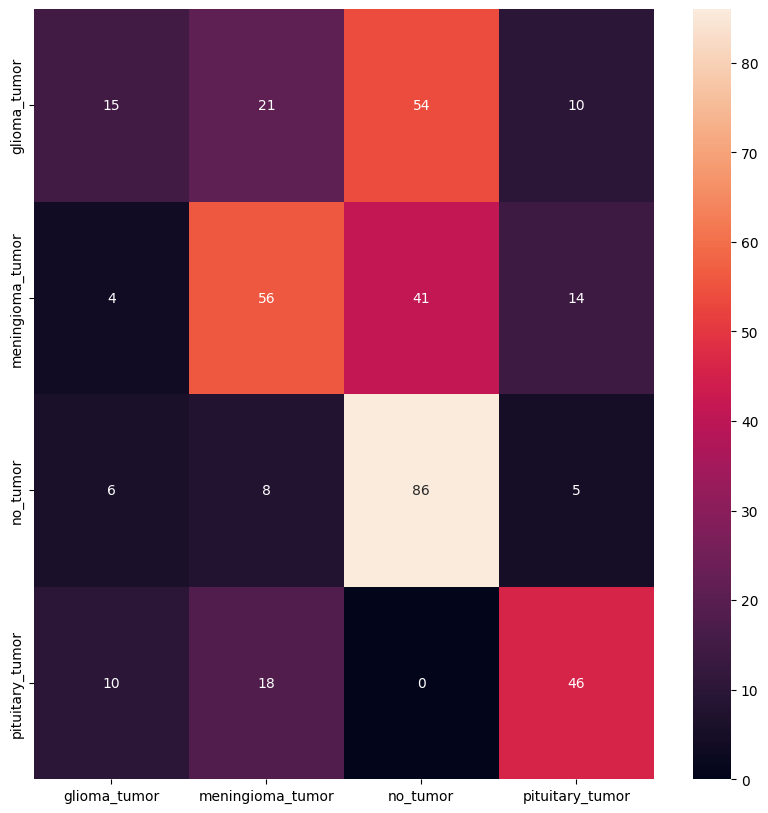

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

# we plot a confusion matrix to see the performance of the model
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((4, 4))
model.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = train_dataset.classes
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

Our model seems to be having issues with classifying glioma tumors, but otherwise, surprisingly accurate

We can try a slightly more complicated framework using multiple convolution layers and multiple FC layers to see if a more complicated network performs better

## Attempt 2: Two-Conv and Two-FC

In [10]:
# we try again using a more complex model, we do two convolutional layers and two fully connected layers
model_cp = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(32*64*64, 128),
    nn.ReLU(),
    nn.Linear(128, 4))

# move the model to the GPU if available
model_cp.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cp.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
train_temp = train_loader_gpu if torch.cuda.is_available() else train_loader
for epoch in range(n_epochs):
    model_cp.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_cp(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()


Epoch 1/10 - Loss: 0.32053929567337036 performed in 2.760057210922241 seconds
Epoch 2/10 - Loss: 0.10568895936012268 performed in 2.736860513687134 seconds
Epoch 3/10 - Loss: 0.08224623650312424 performed in 2.804685115814209 seconds
Epoch 4/10 - Loss: 0.027195213362574577 performed in 2.8574976921081543 seconds
Epoch 5/10 - Loss: 0.009430045261979103 performed in 3.0525710582733154 seconds
Epoch 6/10 - Loss: 0.013673043809831142 performed in 3.0890004634857178 seconds
Epoch 7/10 - Loss: 0.002619783394038677 performed in 3.354957103729248 seconds
Epoch 8/10 - Loss: 0.0014116504462435842 performed in 3.403707265853882 seconds
Epoch 9/10 - Loss: 0.001967322314158082 performed in 3.4050610065460205 seconds
Epoch 10/10 - Loss: 6.885536276968196e-05 performed in 3.4052462577819824 seconds


In [11]:
# test the model accuracy with loss
model_cp.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data, target in test_loader_gpu:
        output = model_cp(data)
        loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {correct/total:.4f}, Batch Loss: {loss/len(test_loader_gpu):.2f}')


Accuracy: 0.7792, Batch Loss: 3.74


We seem to have gotten more or less the same accuracy...

<Axes: >

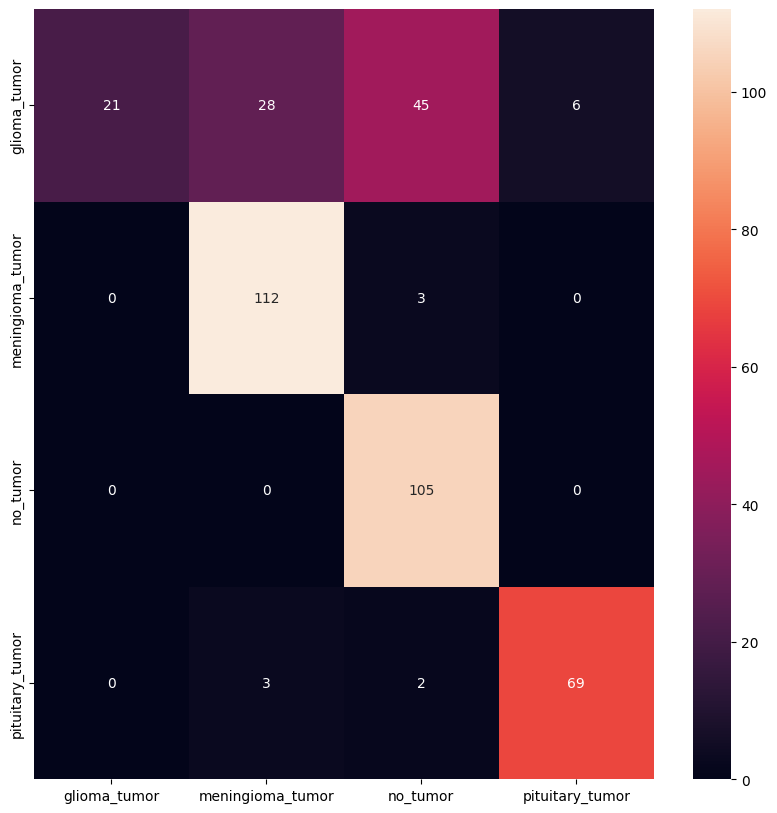

In [12]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((4, 4))
model_cp.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model_cp(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = train_dataset.classes
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

In [13]:
# we can try loading the images at a higher resolution, but we should check what the minimum dimensions are
min_x = 10000
min_y = 10000

for root, dirs, files in os.walk(train_path):
    for file in files:
        if file.endswith('.jpg'):
            img = plt.imread(os.path.join(root, file))
            x, y = img.shape[:2]
            min_x = min(x, min_x)
            min_y = min(y, min_y)

print(min_x, min_y)

198 180


Apparently, we're already overshooting our minimum dimensions! Just to see: what happens if we resize to a smaller resolution?

## Attempt 3: Smaller Image Transform

In [14]:
data_transform_sm = transforms.Compose(
    [transforms.Resize((128, 128)), 
    transforms.ToTensor()])

# define the new smaller datasets using ImageFolder
train_dataset_sm = datasets.ImageFolder(root=train_path, transform=data_transform_sm)
test_dataset_sm = datasets.ImageFolder(root=test_path, transform=data_transform_sm)

# define the new smaller dataloaders
train_loader_sm = DataLoader(dataset=train_dataset_sm, batch_size=32, shuffle=True)
test_loader_sm = DataLoader(dataset=test_dataset_sm, batch_size=32, shuffle=True)

# move to gpu if available
if torch.cuda.is_available():
    train_loader_gpu_sm = [(data.to(device), target.to(device)) for data, target in train_loader_sm]
    test_loader_gpu_sm = [(data.to(device), target.to(device)) for data, target in test_loader_sm]

In [15]:
# simple CNN model with one convolutional layer and one fully connected layer
model_sm = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*64*64, 4))

# move the model to the GPU if available
model_sm.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sm.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
first_start = start_time
train_temp = train_loader_gpu_sm if torch.cuda.is_available() else train_loader_sm
for epoch in range(n_epochs):
    model_sm.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_sm(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()
print(f'Total Train Time: {time.time() - first_start} seconds')

Epoch 1/10 - Loss: 0.7938730716705322 performed in 0.4202914237976074 seconds
Epoch 2/10 - Loss: 0.3264860212802887 performed in 0.41841983795166016 seconds
Epoch 3/10 - Loss: 0.22016143798828125 performed in 0.41675472259521484 seconds
Epoch 4/10 - Loss: 0.147358700633049 performed in 0.4173276424407959 seconds
Epoch 5/10 - Loss: 0.12115149199962616 performed in 0.41718196868896484 seconds
Epoch 6/10 - Loss: 0.08297188580036163 performed in 0.4160330295562744 seconds
Epoch 7/10 - Loss: 0.0609125941991806 performed in 0.41667890548706055 seconds
Epoch 8/10 - Loss: 0.29846489429473877 performed in 0.4169344902038574 seconds
Epoch 9/10 - Loss: 0.031201360747218132 performed in 0.4166393280029297 seconds
Epoch 10/10 - Loss: 0.015598616562783718 performed in 0.41646885871887207 seconds
Total Train Time: 4.173526763916016 seconds


In [16]:
# test the model accuracy and loss
model_sm.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data, target in test_loader_gpu_sm:
        output = model_sm(data)
        loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {correct/total:.4f}, Batch Loss: {loss/len(test_loader_gpu_sm):.2f}')

Accuracy: 0.7259, Batch Loss: 3.63


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x262144 and 65536x4)

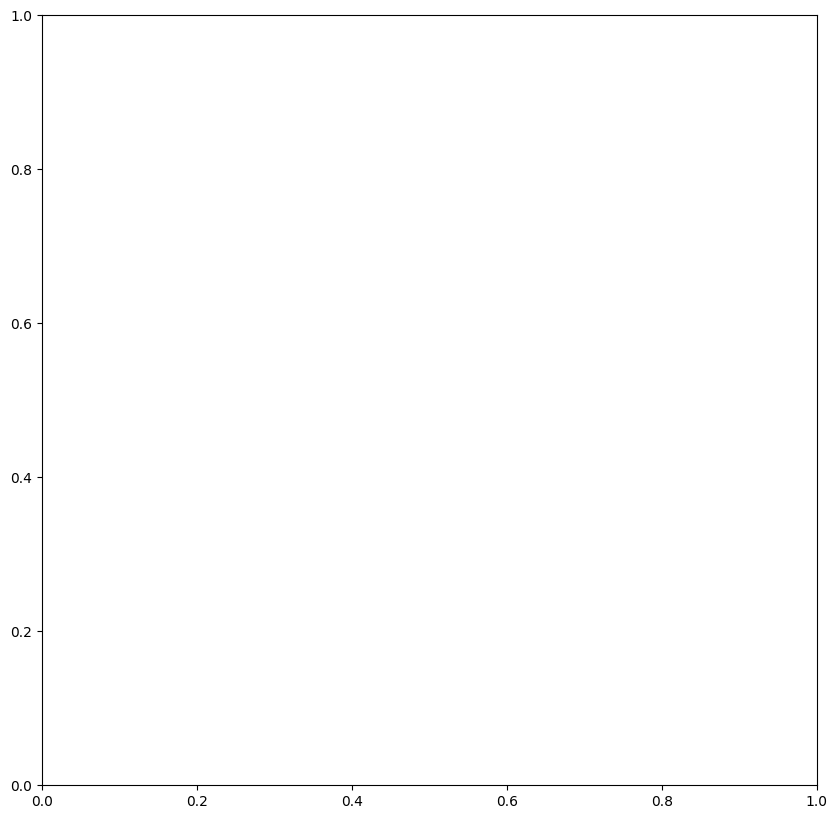

In [17]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((4, 4))
model.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model_sm(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = train_dataset.classes
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

Since we seem to be having issues with glioma tumours specifically with confusion against no tumours, we can try a two-step
classification. First, we see if there is a tumour. Then, we classify what kind of tumour it is

## Attempt 4: Two-Step Classification

In [ ]:
# we try again, but classes 0,1,and 3 are merged into one class first
# we need to redefine the dataset and the dataloader

train_dataset_bin = datasets.ImageFolder(root=train_path, transform=data_transform_sm)
test_dataset_bin = datasets.ImageFolder(root=test_path, transform=data_transform_sm)

class_mapping = {0: 1, 1: 1, 2: 0, 3: 1}

class DatasetBinary(Dataset):
    def __init__(self, dataset, class_mapping):
        self.dataset = dataset
        self.class_mapping = class_mapping
        self.targets = [class_mapping[target] for _, target in self.dataset]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        return data, self.class_mapping[target]

train_dataset_bin = DatasetBinary(train_dataset_bin, class_mapping)
test_dataset_bin = DatasetBinary(test_dataset_bin, class_mapping)

train_loader_bin = DataLoader(dataset=train_dataset_bin, batch_size=32, shuffle=True)
test_loader_bin = DataLoader(dataset=test_dataset_bin, batch_size=32, shuffle=True)


In [ ]:
# we should check the distribution of the classes in the dataset
class_distribution = {}
for _, target in train_loader_bin:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("train", class_distribution)

train {1: 2475, 0: 395}


Huh, well the imbalance is certainly a problem. We can guard against this using a weighted sampler

In [ ]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Calculate class weights as the inverse of their frequencies
class_counts = Counter(train_dataset_bin.targets)
total_samples = sum(class_counts.values())
class_weights = {class_idx: total_samples / count for class_idx, count in class_counts.items()}

# Calculate sampling weights for each instance in the dataset
sample_weights = [class_weights[target] for target in train_dataset_bin.targets]

# Define the sampler for the DataLoader
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Define the DataLoader with the sampler
train_loader_bin_weighted = DataLoader(dataset=train_dataset_bin, batch_size=64, sampler=sampler)

In [ ]:
# distribution of the classes in the dataset
class_distribution = {}
for _, target in train_loader_bin_weighted:
    for label in target:
        if label.item() in class_distribution:
            class_distribution[label.item()] += 1
        else:
            class_distribution[label.item()] = 1
print("train", class_distribution)

train {1: 1435, 0: 1435}


Looks good! We can start training

In [ ]:
# move the loaders to the GPU if available
if torch.cuda.is_available():
    train_loader_gpu_bin = [(data.to(device), target.to(device)) for data, target in train_loader_bin_weighted]
    test_loader_gpu_bin = [(data.to(device), target.to(device)) for data, target in test_loader_bin]


# simple CNN model with one convolutional layer and one fully connected layer
model_bin = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16*64*64, 2))

# move the model to the GPU if available
model_bin.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bin.parameters(), lr=0.001)

# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 10
start_time = time.time()
first_start = start_time
train_temp = train_loader_gpu_bin if torch.cuda.is_available() else train_loader_bin
for epoch in range(n_epochs):
    model_bin.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_bin(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()
print(f'Total Train Time: {time.time() - first_start} seconds')

Epoch 1/10 - Loss: 0.21699067950248718 performed in 0.343336820602417 seconds
Epoch 2/10 - Loss: 0.16363368928432465 performed in 0.30025672912597656 seconds
Epoch 3/10 - Loss: 0.05205157399177551 performed in 0.3016035556793213 seconds
Epoch 4/10 - Loss: 0.029501376673579216 performed in 0.30678772926330566 seconds
Epoch 5/10 - Loss: 0.0225226953625679 performed in 0.30269360542297363 seconds
Epoch 6/10 - Loss: 0.011280137114226818 performed in 0.3023059368133545 seconds
Epoch 7/10 - Loss: 0.007602171041071415 performed in 0.30551886558532715 seconds
Epoch 8/10 - Loss: 0.006608223542571068 performed in 0.30379629135131836 seconds
Epoch 9/10 - Loss: 0.008137804456055164 performed in 0.3033418655395508 seconds
Epoch 10/10 - Loss: 0.004275437444448471 performed in 0.30433177947998047 seconds
Total Train Time: 3.074852705001831 seconds


In [ ]:
# test the model accuracy and loss
model_bin.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data, target in test_loader_gpu_bin:
        output = model_bin(data)
        loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {correct/total:.4f}, Batch Loss: {loss/len(test_loader_gpu_bin):.2f}')

Accuracy: 0.6929, Batch Loss: 2.17


<Axes: >

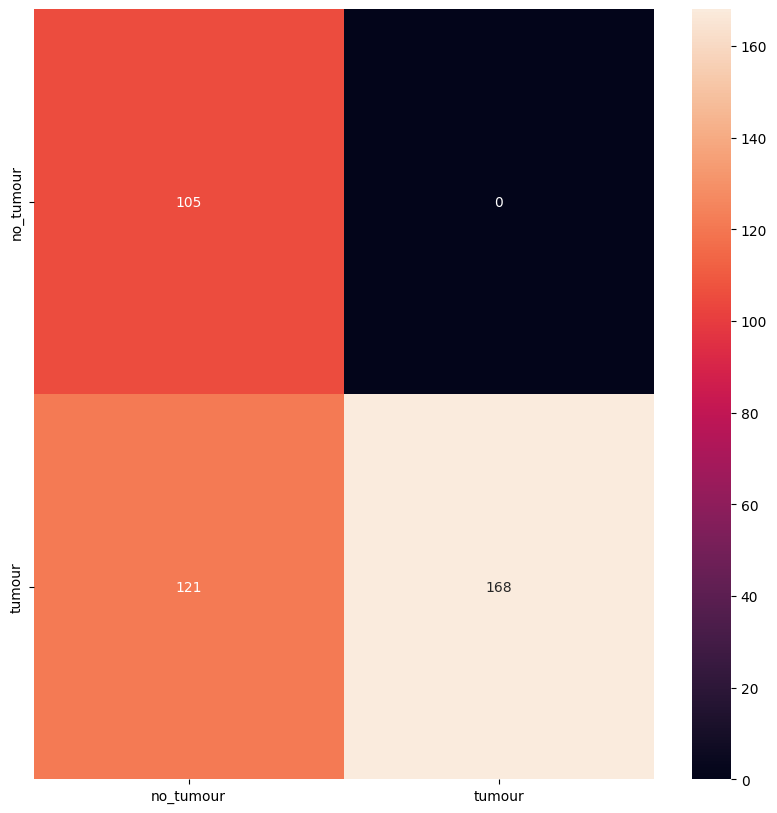

In [ ]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((2, 2))
model_bin.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model_bin(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = ['no_tumour', 'tumour']
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

That's not great. We should try a slightly more complicated model next time, but this 2-step classification is promising

## Attempt 4b: Using a Dropout layer to help prevent overfitting of the no_tumour class

In [ ]:
# the model is overfitting, we can try to add dropout layers and also use more convolutional layers
model_bin_dropout = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.5),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.5),
    nn.Flatten(),
    nn.Linear(32*32*32, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2))

# move the model to the GPU if available
model_bin_dropout.to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bin_dropout.parameters(), lr=0.001)

In [ ]:
# train the model and time each epoch. The code should work with both CPU and GPU
n_epochs = 25
start_time = time.time()
first_start = start_time
train_temp = train_loader_gpu_bin if torch.cuda.is_available() else train_loader_bin

for epoch in range(n_epochs):
    model_bin_dropout.train()    
    for data, target in train_temp:
        optimizer.zero_grad()
        output = model_bin_dropout(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {loss.item()} performed in {time.time() - start_time} seconds')
    start_time = time.time()
print(f'Total Train Time: {time.time() - first_start} seconds')


Epoch 1/25 - Loss: 0.4034050405025482 performed in 0.7060151100158691 seconds
Epoch 2/25 - Loss: 0.36020660400390625 performed in 0.6518359184265137 seconds
Epoch 3/25 - Loss: 0.2232876420021057 performed in 0.6476285457611084 seconds
Epoch 4/25 - Loss: 0.17842723429203033 performed in 0.652508020401001 seconds
Epoch 5/25 - Loss: 0.11267595738172531 performed in 0.6516916751861572 seconds
Epoch 6/25 - Loss: 0.12872278690338135 performed in 0.6507692337036133 seconds
Epoch 7/25 - Loss: 0.051262907683849335 performed in 0.6521806716918945 seconds
Epoch 8/25 - Loss: 0.062061816453933716 performed in 0.6521914005279541 seconds
Epoch 9/25 - Loss: 0.051950469613075256 performed in 0.6523983478546143 seconds
Epoch 10/25 - Loss: 0.03495554253458977 performed in 0.6525709629058838 seconds
Epoch 11/25 - Loss: 0.03168989717960358 performed in 0.6538655757904053 seconds
Epoch 12/25 - Loss: 0.014915739186108112 performed in 0.6529972553253174 seconds
Epoch 13/25 - Loss: 0.06631405651569366 performe

In [ ]:
# test the model accuracy with loss
model_bin_dropout.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data, target in test_loader_gpu_bin:
        output = model_bin_dropout(data)
        loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Accuracy: {correct/total:.4f}, Batch Loss: {loss/len(test_loader_gpu_bin):.2f}')

Accuracy: 0.7107, Batch Loss: 1.97


<Axes: >

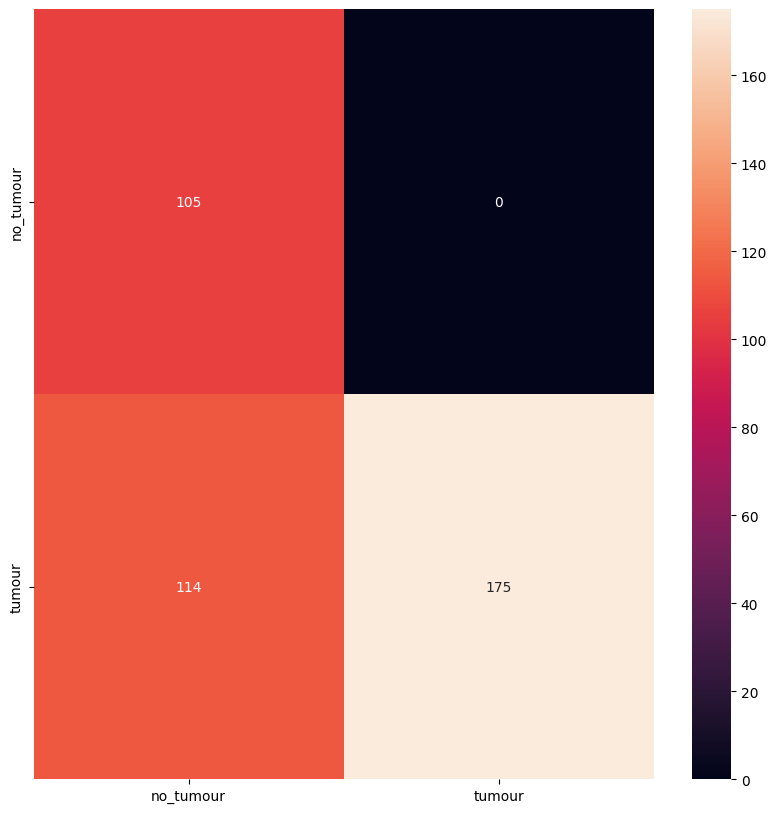

In [ ]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((2, 2))
model_bin_dropout.eval()
with torch.no_grad():
    for data, target in test_temp:
        output = model_bin_dropout(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = ['no_tumour', 'tumour']
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)


<Axes: >

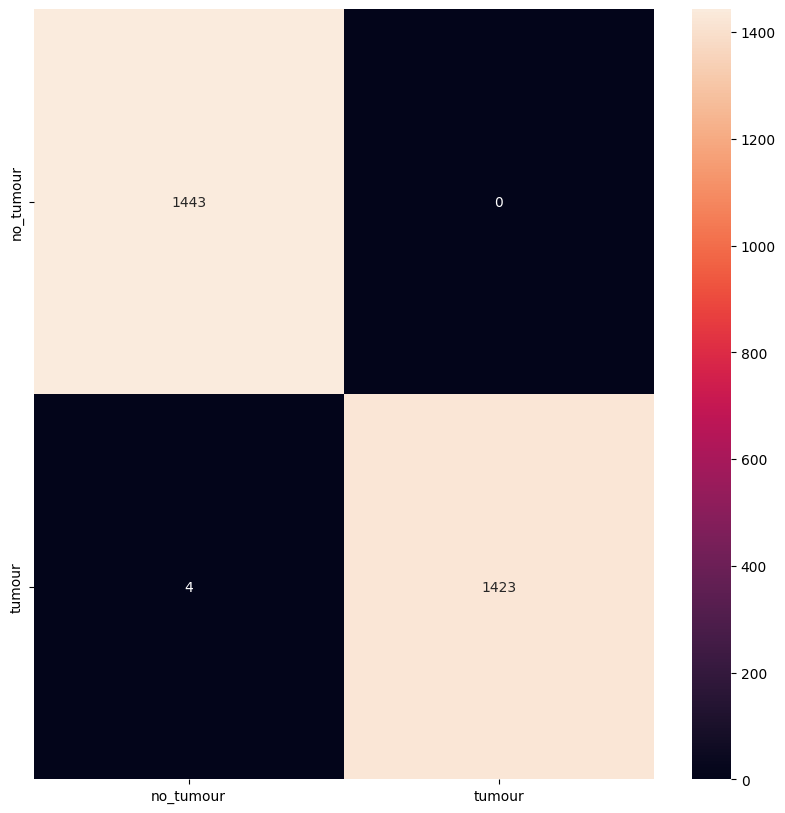

In [ ]:
# just to be sure, let's plot the confusion matrix for the training set too
fig, ax = plt.subplots(figsize=(10, 10))
confusion_matrix = np.zeros((2, 2))
model_bin_dropout.eval()
with torch.no_grad():
    for data, target in train_temp:
        output = model_bin_dropout(data)
        _, predicted = torch.max(output, 1)
        for i in range(len(predicted)):
            confusion_matrix[target[i]][predicted[i]] += 1
# convert the confusion matrix to an integer 2d array
confusion_matrix = confusion_matrix.astype(int)
classes = ['no_tumour', 'tumour']
sns.heatmap(confusion_matrix, annot=True, fmt = 'd', xticklabels=classes, yticklabels=classes, ax=ax)

## We will try pretrained models next time to see if we can make any headway on the image features